In [16]:
#this is the core ML and ANN
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

#handles numerical and data handling
import numpy as np
import pandas as pd

#For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for File Management
import os

#Evaluation Tools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

#For image prediction
from tensorflow.keras.preprocessing import image

In [17]:
#Dataset on Google Drive
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/Fabric_Defect_Datasets2/train"
test_dir = "/content/drive/MyDrive/Fabric_Defect_Datasets2/test"

#image size and batch size
img_size = (128, 128)
batch_size = 8
num_classes = 3  #For Damaged, Normal, and Stains

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    channel_shift_range=30,
    validation_split=0.2  # 20% for validation
)

#Data generator for test (no augmentation, only rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

#Training dataset
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    subset='training'
)

#Validation dataset
val_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)

#Test dataset
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

#checking for indices
print("Class indices:", train_ds.class_indices)

Found 711 images belonging to 3 classes.
Found 176 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Class indices: {'damaged': 0, 'normal': 1, 'stains': 2}


In [19]:
#compute class weights to handle imbalance
classes = np.unique(train_ds.classes)
class_weights = compute_class_weight('balanced', classes=classes, y=train_ds.classes)
class_weights_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weights_dict)

Class weights: {np.int32(0): np.float64(1.025974025974026), np.int32(1): np.float64(0.9957983193277311), np.int32(2): np.float64(0.9793388429752066)}


In [20]:
#Early stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [21]:
#the CNN model
from tensorflow.keras import regularizers

def create_cnn_model(input_shape=(128,128,3), num_classes=3):
    model = models.Sequential([
        #block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        #block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        #block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        #block 4 - (with L2 Regularization to prevent overfitting deep features)
        layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        #GlobalAveragePooling used to average the feature maps, making the model robust to where the defect is located
        layers.GlobalAveragePooling2D(),

        layers.Dropout(0.4), #increased Dropout slightly

        #Dense Layer
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

        #Output (softmax for multiclass: 3 classes)
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [22]:
# Hyperparameter Tuning 1: Adam
model1 = create_cnn_model()
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights_dict  # optional, for imbalance
)

# Evaluate on test set
test_loss1, test_acc1 = model1.evaluate(test_ds)
print(f"Adam Optimizer Test Accuracy: {test_acc1:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.4847 - loss: 1.5033 - val_accuracy: 0.3352 - val_loss: 1.4875
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - accuracy: 0.5020 - loss: 1.4200 - val_accuracy: 0.3523 - val_loss: 1.8049
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 343ms/step - accuracy: 0.5752 - loss: 1.3931 - val_accuracy: 0.3409 - val_loss: 2.0274
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 354ms/step - accuracy: 0.5825 - loss: 1.3258 - val_accuracy: 0.3466 - val_loss: 2.0424
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - accuracy: 0.5580 - loss: 1.2875 - val_accuracy: 0.3693 - val_loss: 1.8774
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 342ms/step - accuracy: 0.5877 - loss: 1.3124 - val_accuracy: 0.4261 - val_loss: 1.7429
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 353ms/step - accuracy: 0.5707 - loss: 1.2936 - val_accuracy: 0.4375 - val_loss: 1.5332
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 348ms/step - accuracy: 0.5860 - loss: 1.2393 - val_accura

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step


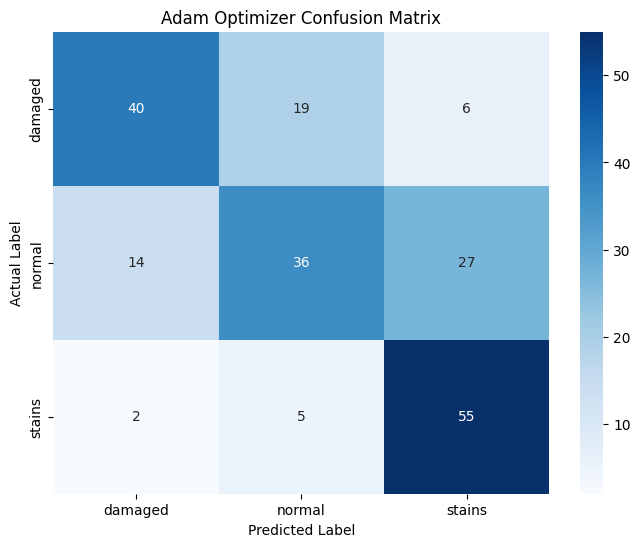

--- Adam Optimizer Classification Report ---
              precision    recall  f1-score   support

     damaged       0.71      0.62      0.66        65
      normal       0.60      0.47      0.53        77
      stains       0.62      0.89      0.73        62

    accuracy                           0.64       204
   macro avg       0.65      0.66      0.64       204
weighted avg       0.64      0.64      0.63       204



In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_performance(model, test_ds, model_name):
    #set the shuffle to False to ensure order is consistent
    test_ds.shuffle = False

    #Get Predictions
    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    #get True Labels
    true_classes = test_ds.classes
    class_labels = list(test_ds.class_indices.keys())

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    #detailed report (Precision, Recall, F1-Score)
    print(f"--- {model_name} Classification Report ---")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

plot_model_performance(model1, test_ds, "Adam Optimizer")

In [24]:
# Hyperparameter Tuning 2: SGD + Momentum
model2 = create_cnn_model()
model2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

test_loss2, test_acc2 = model2.evaluate(test_ds)
print(f"SGD + Momentum Test Accuracy: {test_acc2:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 413ms/step - accuracy: 0.4398 - loss: 1.8155 - val_accuracy: 0.3409 - val_loss: 1.6708
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 348ms/step - accuracy: 0.5166 - loss: 1.4160 - val_accuracy: 0.3409 - val_loss: 1.8280
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 358ms/step - accuracy: 0.4996 - loss: 1.4494 - val_accuracy: 0.3523 - val_loss: 1.8226
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.5733 - loss: 1.3138 - val_accuracy: 0.3125 - val_loss: 1.5392
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.5441 - loss: 1.3145 - val_accuracy: 0.4034 - val_loss: 1.5852
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 361ms/step - accuracy: 0.5477 - loss: 1.3303 - val_accuracy: 0.4375 - val_loss: 1.5873
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.5446 - loss: 1.2791 - val_accuracy: 0.4375 - val_loss: 1.6072
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 340ms/step - accuracy: 0.5616 - loss: 1.3124 - val_accu

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step


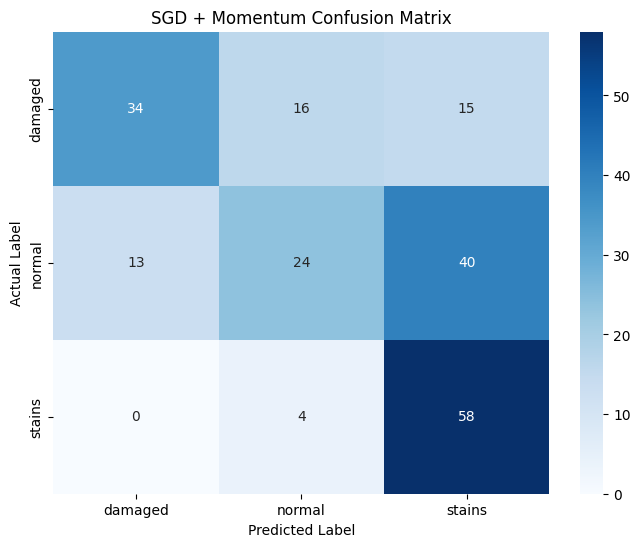

--- SGD + Momentum Classification Report ---
              precision    recall  f1-score   support

     damaged       0.72      0.52      0.61        65
      normal       0.55      0.31      0.40        77
      stains       0.51      0.94      0.66        62

    accuracy                           0.57       204
   macro avg       0.59      0.59      0.56       204
weighted avg       0.59      0.57      0.54       204



In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_performance(model, test_ds, model_name):
    #set the shuffle to False to ensure order is consistent
    test_ds.shuffle = False

    #Get Predictions
    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    #get True Labels
    true_classes = test_ds.classes
    class_labels = list(test_ds.class_indices.keys())

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    #detailed report (Precision, Recall, F1-Score)
    print(f"--- {model_name} Classification Report ---")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

plot_model_performance(model2, test_ds, "SGD + Momentum")

In [26]:
# Hyperparameter Tuning 3: RMSProp
model3 = create_cnn_model()
model3.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

test_loss3, test_acc3 = model3.evaluate(test_ds)
print(f"RMSProp Test Accuracy: {test_acc3:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.4607 - loss: 1.7758 - val_accuracy: 0.3750 - val_loss: 1.7928
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 345ms/step - accuracy: 0.4902 - loss: 1.5556 - val_accuracy: 0.3409 - val_loss: 2.6168
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 394ms/step - accuracy: 0.5092 - loss: 1.4004 - val_accuracy: 0.3352 - val_loss: 1.9792
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.5383 - loss: 1.3242 - val_accuracy: 0.3920 - val_loss: 2.1005
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 342ms/step - accuracy: 0.5661 - loss: 1.2396 - val_accuracy: 0.3295 - val_loss: 1.5810
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.5554 - loss: 1.2294 - val_accuracy: 0.4773 - val_loss: 1.3557
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 337ms/step - accuracy: 0.6172 - loss: 1.1484 - val_accuracy: 0.3352 - val_loss: 1.3608
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 340ms/step - accuracy: 0.5331 - loss: 1.1752 - val_accu

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step


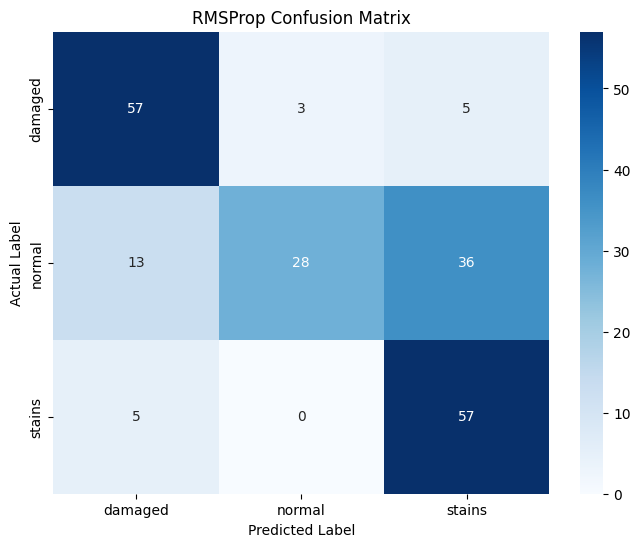

--- RMSProp Classification Report ---
              precision    recall  f1-score   support

     damaged       0.76      0.88      0.81        65
      normal       0.90      0.36      0.52        77
      stains       0.58      0.92      0.71        62

    accuracy                           0.70       204
   macro avg       0.75      0.72      0.68       204
weighted avg       0.76      0.70      0.67       204



In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_performance(model, test_ds, model_name):
    #set the shuffle to False to ensure order is consistent
    test_ds.shuffle = False

    #Get Predictions
    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    #get True Labels
    true_classes = test_ds.classes
    class_labels = list(test_ds.class_indices.keys())

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    #detailed report (Precision, Recall, F1-Score)
    print(f"--- {model_name} Classification Report ---")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

plot_model_performance(model3, test_ds, "RMSProp")

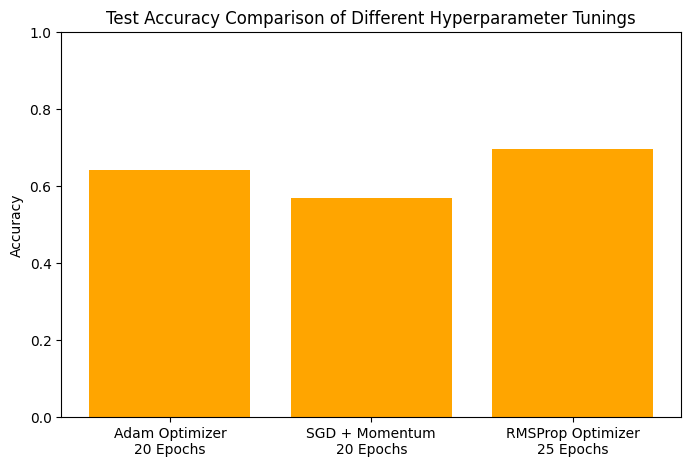

In [28]:
experimental = ['Adam Optimizer\n20 Epochs', 'SGD + Momentum\n20 Epochs', 'RMSProp Optimizer\n25 Epochs']
accuracies = [test_acc1, test_acc2, test_acc3]

plt.figure(figsize=(8,5))
plt.bar(experimental, accuracies, color='orange')
plt.title("Test Accuracy Comparison of Different Hyperparameter Tunings")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

Saving IMG_20251210_140405.jpg to IMG_20251210_140405.jpg
Saving IMG_20251210_135913.jpg to IMG_20251210_135913.jpg
Saving 288635af6a62b2c9754478b663abf6e4.jpg to 288635af6a62b2c9754478b663abf6e4.jpg
Saving 787b9c140fb0e53f81d73aad9de0006a.jpg to 787b9c140fb0e53f81d73aad9de0006a.jpg
Saving IMG_20251209_125123.jpg to IMG_20251209_125123.jpg
Saving IMG_20251209_125149.jpg to IMG_20251209_125149.jpg
Saving download.avif to download.avif


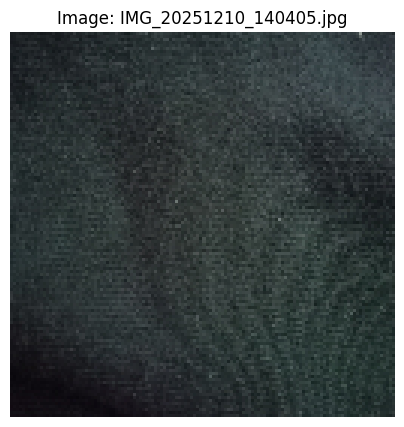

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
Model: Adam | Predicted: normal | Confidence: 0.4934
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
Model: SGD + Momentum | Predicted: normal | Confidence: 0.5480


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
Model: RMSProp | Predicted: normal | Confidence: 0.7439
--------------------------------------------------


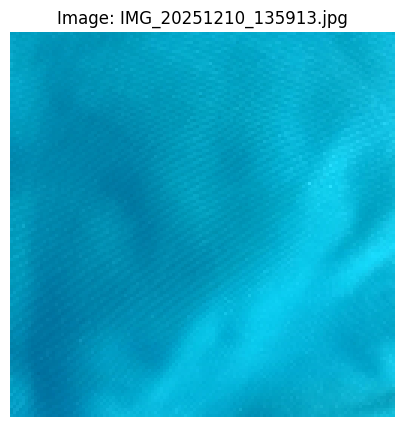

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Model: Adam | Predicted: damaged | Confidence: 0.8386
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Model: SGD + Momentum | Predicted: damaged | Confidence: 0.9928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Model: RMSProp | Predicted: damaged | Confidence: 0.8478
--------------------------------------------------


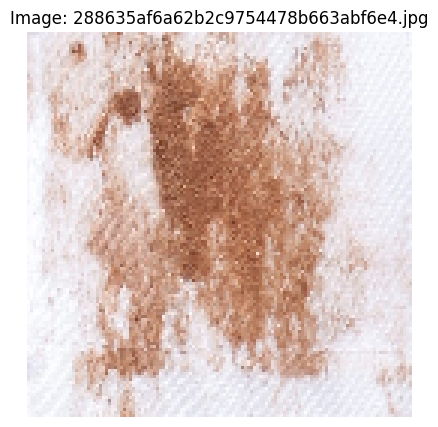

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model: Adam | Predicted: normal | Confidence: 0.4986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Model: SGD + Momentum | Predicted: normal | Confidence: 0.5621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Model: RMSProp | Predicted: damaged | Confidence: 0.5125
--------------------------------------------------


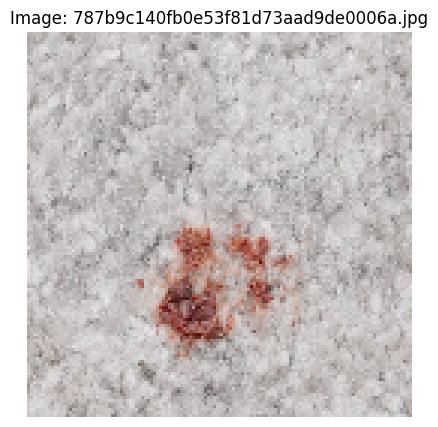

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model: Adam | Predicted: damaged | Confidence: 0.4068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Model: SGD + Momentum | Predicted: stains | Confidence: 0.4706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model: RMSProp | Predicted: damaged | Confidence: 0.5576
--------------------------------------------------


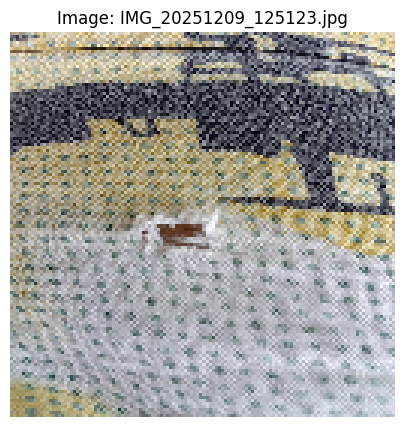

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Model: Adam | Predicted: damaged | Confidence: 0.5179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model: SGD + Momentum | Predicted: damaged | Confidence: 0.4234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Model: RMSProp | Predicted: damaged | Confidence: 0.8142
--------------------------------------------------


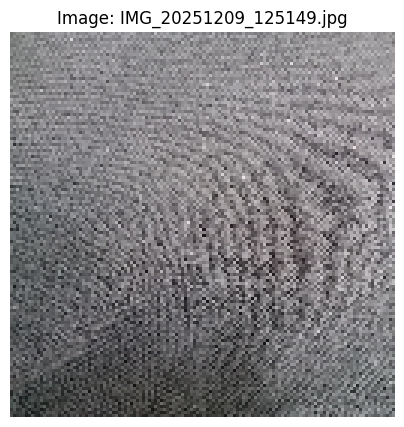

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model: Adam | Predicted: normal | Confidence: 0.6068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Model: SGD + Momentum | Predicted: damaged | Confidence: 0.3673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model: RMSProp | Predicted: damaged | Confidence: 0.5346
--------------------------------------------------


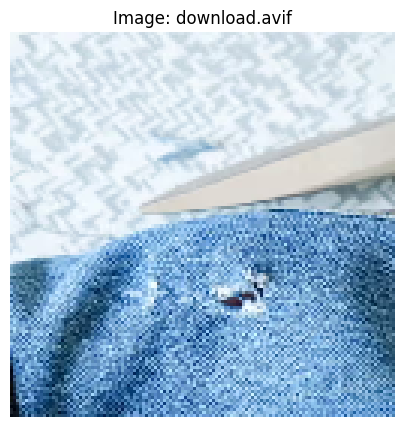

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Model: Adam | Predicted: damaged | Confidence: 0.8283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model: SGD + Momentum | Predicted: damaged | Confidence: 0.7632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Model: RMSProp | Predicted: damaged | Confidence: 0.7066
--------------------------------------------------


In [29]:
# Upload images (Colab)
from google.colab import files
uploaded = files.upload()

# List of models to compare
models_list = [
    ("Adam", model1),
    ("SGD + Momentum", model2),
    ("RMSProp", model3)
]

# Class names in order
class_names = ['damaged', 'normal', 'stains']

# Loop through each uploaded image
for img_name, img_data in uploaded.items():
    # Save image
    with open(img_name, 'wb') as f:
        f.write(img_data)

    # Load and preprocess
    img = image.load_img(img_name, target_size=(128,128))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Display the image once
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Image: {img_name}")
    plt.axis('off')
    plt.show()

    # Predict with all models
    for model_name, model in models_list:
        preds = model.predict(img_array)
        pred_class = np.argmax(preds[0])
        confidence = np.max(preds[0])
        predicted_label = class_names[pred_class]

        print(f"Model: {model_name} | Predicted: {predicted_label} | Confidence: {confidence:.4f}")
    print("-"*50)  # Separator for clarity

In [30]:
model.save("fabric_defect_detection_model.h5")

In [31]:
from google.colab import files
files.download("fabric_defect_detection_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>